In [1]:
import os
import sys
from pathlib import Path

cwd_path = cwd_path = Path(os.getcwd()).absolute().parents[0]
parent_path = cwd_path.parents[0]
sys.path.insert(0, parent_path.as_posix())
sys.path.insert(0, cwd_path.parents[0].parents[0].as_posix()) # Root

import numpy as np
from scipy.io import loadmat  # loading data from matlab
from mayavi import mlab
import matplotlib.pyplot as plt
from pymanopt.manifolds import Euclidean, Sphere, Product

from SkillsRefining.skills.mps.gmr.manifold_statistics import compute_frechet_mean, compute_weighted_frechet_mean
from SkillsRefining.skills.mps.gmr.manifold_clustering import manifold_k_means, manifold_gmm_em
from SkillsRefining.skills.mps.gmr.manifold_gmr import manifold_gmr
from SkillsRefining.utils.plot_sphere_mayavi import plot_sphere, plot_gaussian_mesh_on_tangent_plane

### Load Data

In [2]:
letter = 'C'
# exp_dir = './examples/MovementPrimitives/'
datapath = '2Dletters/'
data = loadmat(datapath + '%s.mat' % letter)
demos = [d['pos'][0][0].T for d in data['demos'][0]]

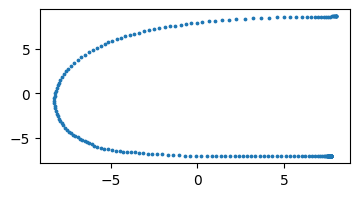

In [3]:
fig = plt.figure(figsize=(4,2))
plt.scatter(demos[2][:, 0], demos[2][:, 1], s=3)

### Parameters

In [4]:
nb_data = demos[0].shape[0]
nb_data_sup = 50
nb_samples = 5
dt = 0.06
input_dim = 2
output_dim = 2
in_idx = [0, 1]
out_idx = [2, 3]
nb_states = 3

In [5]:
# Create velocity data
demos_dx = np.array([(demos[i][2:, :] - demos[i][:-2, :])/dt for i in range(nb_samples)])
demos = [demos[i][1:-1, :] for i in range(nb_samples)]

# Stack position and velocity data
demos_xdx = [np.hstack([demos[i], demos_dx[i]]) for i in range(nb_samples)]

# Stack demos
demos_np = demos_xdx[0]
for i in range(1, nb_samples):
    demos_np = np.vstack([demos_np, demos_xdx[i]])

### Verifiy Velocity Data

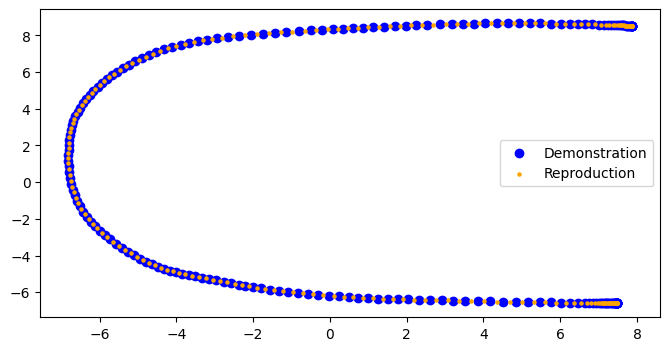

In [6]:
sampled_path = []
sampling_dt = 0.03
rand_idx = np.random.randint(0, len(demos_xdx))
true_x = demos_xdx[rand_idx]
x = true_x[0, :2]
for t in range(len(true_x)):
    sampled_path.append(x)
    delta_x = sampling_dt * demos_xdx[rand_idx][t, 2:]
    x = x + delta_x
sampled_path = np.array(sampled_path)
fig = plt.figure(figsize=(8,4))
plt.scatter(true_x[:, 0], true_x[:, 1], color='blue', label='Demonstration')
plt.scatter(sampled_path[:, 0], sampled_path[:, 1], s=5, color='orange', label='Reproduction')
plt.legend()
plt.show()

In [7]:
X = demos_np[:, :2]
Y = demos_np[:, 2:]

X = 2 * X / (np.max(X, axis=0) - np.min(X, axis=0))
X = X / np.linalg.norm(X, axis=1)[:, None]

Y = 2 * Y / (np.max(Y, axis=0) - np.min(Y, axis=0))
Y = Y / np.linalg.norm(Y, axis=1)[:, None]

In [8]:
demos_np[0]

array([ 7.83242221e+00,  8.48432056e+00, -5.70937850e-05,  2.16123415e-11])

In [9]:
# Input on a sphere
# X = 2 * X / (np.max(X, axis=0) - np.min(X, axis=0))
# X[:, 1] = np.ones(X.shape[0])
# X = np.hstack((X, np.ones((X.shape[0], 1))))
# X = X / np.linalg.norm(X, axis=1)[:, None]

In [10]:
# Output on a sphere
# Y = 2 * Y / (np.max(Y, axis=0) - np.min(Y, axis=0))
# Y[:, 1] = np.ones(Y.shape[0])
# Y = np.hstack((Y, np.ones((Y.shape[0], 1))))
# Y = Y / np.linalg.norm(Y, axis=1)[:, None]

In [11]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
# plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    if X.shape[-1] == 2:
        mlab.points3d(X[p * nb_data:(p + 1) * nb_data, 0],
                      X[p * nb_data:(p + 1) * nb_data, 1],
                      np.ones(X[p * nb_data:(p + 1) * nb_data, 1].shape),
                      color=(0., 0., 0.),
                      scale_factor=0.03)
    else:
        mlab.points3d(X[p * nb_data:(p + 1) * nb_data, 0],
                      X[p * nb_data:(p + 1) * nb_data, 1],
                      X[p * nb_data:(p + 1) * nb_data, 2],
                      color=(0., 0., 0.),
                      scale_factor=0.03)
mlab.view(30, 120)
mlab.show()

In [12]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
# plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    if Y.shape[-1] == 2:
        mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
                      Y[p * nb_data:(p + 1) * nb_data, 1],
                      np.ones(Y[p * nb_data:(p + 1) * nb_data, 1].shape),
                      color=(0., 0., 0.),
                      scale_factor=0.03)
    else:
        mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
                      Y[p * nb_data:(p + 1) * nb_data, 1],
                      Y[p * nb_data:(p + 1) * nb_data, 2],
                      color=(0., 0., 0.),
                      scale_factor=0.03)
mlab.view(30, 120)
mlab.show()

In [17]:
# Data in format compatible with pymanopt product of manifolds
data = np.empty((X.shape[0], 2), dtype=object)
for n in range(X.shape[0]):
    data[n] = [X[n], Y[n]]

In [19]:
# Xt = dt * np.arange(nb_data + nb_data_sup)[:, None]

# Create the manifold
input_manifold = Euclidean(input_dim)
# output_manifold = Sphere(output_dim)
output_manifold = Euclidean(output_dim)
manifold = Product([input_manifold, output_manifold])

# Number of clusters
nb_clusters = 3

In [23]:
# K-means
km_means, km_assignments = manifold_k_means(manifold, data, nb_clusters=nb_clusters)

# GMM
initial_covariances = np.concatenate(nb_clusters * [np.eye(input_dim+output_dim)[None]], 0)
initial_priors = np.zeros(nb_clusters)
for k in range(nb_clusters):
    initial_priors[k] = np.sum(km_assignments == k) / nb_data
gmm_means, gmm_covariances, gmm_priors, gmm_assignments = manifold_gmm_em(manifold, data, nb_clusters,
                                                                          initial_means=km_means,
                                                                          initial_covariances=initial_covariances,
                                                                          initial_priors=initial_priors
                                                                          )
# np.savez(filename, gmm_means=gmm_means, gmm_covariances=gmm_covariances, gmm_priors=gmm_priors)

Converged after 48 iterations: 1.386e-01


In [29]:
Xt = dt * np.random.choice(X[:, 0], size=nb_data + nb_data_sup).reshape(-1, 1)

In [30]:
mu_gmr, sigma_gmr, H = manifold_gmr(Xt, manifold, gmm_means, gmm_covariances, gmm_priors)

In [43]:
np.hstack((mu_gmr, np.ones((mu_gmr.shape[0], 1)))).shape

(250, 3)

In [33]:
H.shape

(3, 250)

In [22]:
mlab.figure(1, bgcolor=(1, 1, 1), fgcolor=(0, 0, 0), size=(700, 700))
fig = mlab.gcf()
mlab.clf()
# plot_sphere(figure=fig)
# Plot data on the sphere
for p in range(nb_samples):
    if Y.shape[-1] == 2:
        mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
                      Y[p * nb_data:(p + 1) * nb_data, 1],
                      np.ones(Y[p * nb_data:(p + 1) * nb_data, 1].shape),
                      color=(0., 0., 0.),
                      scale_factor=0.03)
    else:
        mlab.points3d(Y[p * nb_data:(p + 1) * nb_data, 0],
                      Y[p * nb_data:(p + 1) * nb_data, 1],
                      Y[p * nb_data:(p + 1) * nb_data, 2],
                      color=(0., 0., 0.),
                      scale_factor=0.03)

# Plot Gaussians
for k in range(nb_clusters):
    plot_gaussian_mesh_on_tangent_plane(gmm_means[k, 1], gmm_covariances[k, 1:, 1:], color=(0.5, 0, 0.2))

# # Plot GMR trajectory
for n in range(Xt.shape[0]):
    # Plot mean and covariance
    plot_gaussian_mesh_on_tangent_plane(mu_gmr[n], sigma_gmr[n], color=(0.20, 0.54, 0.93))
    # Plot mean only
    mlab.points3d(mu_gmr[n, 0], mu_gmr[n, 1], mu_gmr[n, 2],
                  color=(0.20, 0.54, 0.93),
                  scale_factor=0.03)
mlab.view(30, 120)
# mlab.savefig('Figure0.png')
mlab.show()

IndexError: index 2 is out of bounds for axis 0 with size 2

In [21]:
Xt[:nb_data, 0].shape

(200,)

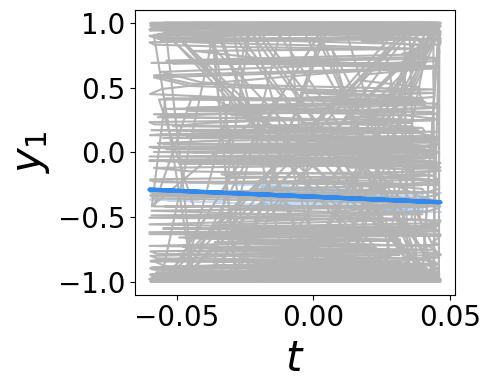

In [27]:
plt.figure(figsize=(5, 4))
for p in range(nb_samples):
    if nb_samples == 5:
        nb_data = 190
    plt.plot(Xt[:nb_data, 0], Y[p * nb_data:(p + 1) * nb_data, 0], color=[.7, .7, .7])
plt.plot(Xt[:, 0], mu_gmr[:, 0], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 0] - np.sqrt(sigma_gmr[:, 0, 0])
maxy = mu_gmr[:, 0] + np.sqrt(sigma_gmr[:, 0, 0])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$y_1$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure1.png', dpi=100)

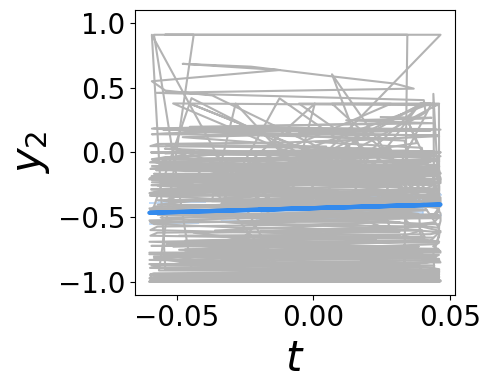

In [30]:
plt.figure(figsize=(5, 4))
for p in range(nb_samples):
    if nb_samples == 5:
        nb_data = 190
    plt.plot(Xt[:nb_data, 0], Y[p * nb_data:(p + 1) * nb_data, 1], color=[.7, .7, .7])
plt.plot(Xt[:, 0], mu_gmr[:, 1], color=[0.20, 0.54, 0.93], linewidth=3)
miny = mu_gmr[:, 1] - np.sqrt(sigma_gmr[:, 1, 1])
maxy = mu_gmr[:, 1] + np.sqrt(sigma_gmr[:, 1, 1])
plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
axes = plt.gca()
axes.set_ylim([-1.1, 1.1])
plt.xlabel('$t$', fontsize=30)
plt.ylabel('$y_2$', fontsize=30)
plt.tick_params(labelsize=20)
plt.tight_layout()
# plt.savefig(exp_dir + 'Figure2.png', dpi=100)
# plt.show()

# plt.figure(figsize=(5, 4))
# for p in range(nb_samples):
#     if nb_samples == 5:
#         nb_data = 190
#     plt.plot(Xt[:nb_data, 0], Y[p * nb_data:(p + 1) * nb_data, 2], color=[.7, .7, .7])
# plt.plot(Xt[:, 0], mu_gmr[:, 2], color=[0.20, 0.54, 0.93], linewidth=3)
# miny = mu_gmr[:, 2] - np.sqrt(sigma_gmr[:, 2, 2])
# maxy = mu_gmr[:, 2] + np.sqrt(sigma_gmr[:, 2, 2])
# plt.fill_between(Xt[:, 0], miny, maxy, color=[0.20, 0.54, 0.93], alpha=0.3)
# axes = plt.gca()
# axes.set_ylim([-1.1, 1.1])
# plt.xlabel('$t$', fontsize=30)
# plt.ylabel('$y_3$', fontsize=30)
# plt.tick_params(labelsize=20)
# plt.tight_layout()
# # plt.savefig(exp_dir + 'Figure3.png', dpi=100)